In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

%matplotlib inline
%config InlineBackend.feature_format = 'retina'

In [365]:
meta_stats = pd.read_csv('../Data/tfi_count_comb.csv')

In [366]:
df = pd.read_csv('../Data/df_with_matrix.csv')

In [367]:
df.From.unique()

array(['m', 'w'], dtype=object)

In [368]:
meta_stats['Ids'] = df.Ids

In [369]:
data_total = df.merge(meta_stats, how = 'inner', on = 'Ids').reset_index(drop = True)

In [370]:
data_total = data_total.drop(['Unnamed: 0.1', 
               'Title', 
               'Geo_Tag', 
               'Where', 
               'Age', 
               'Height', 
               'Body_type', 
                'Body_doc',
                'Body_clean',
               'Datetime',
               'Has_Image',
               'Has_Maps'], axis = 1)

In [420]:
data_total['str_id'] = data_total.Ids.map(lambda x: str(int(x)))
data_total.str_id.head(100)

0     5963091019
1     5962895842
2     5963361358
3     5967210778
4     5967195802
5     5970614840
6     5967607404
7     5967132028
8     5964900703
9     5964722174
10    5970565938
11    5964425745
12    5964417785
13    5964567991
14    5967321493
15    5965055547
16    5965267937
17    5943592711
18    5967080213
19    5967087435
20    5967122332
21    5968179475
22    5965756427
23    5965756167
24    5968325863
25    5935476623
26    5968167218
27    5964209479
28    5964948350
29    5962837597
         ...    
70    5974532648
71    5974514710
72    5974360256
73    5972817435
74    5972780727
75    5968868453
76    5970874319
77    5964117046
78    5974832587
79    5964156114
80    5972805766
81    5973886217
82    5974771295
83    5974340520
84    5975212968
85    5974544747
86    5974592183
87    5972767259
88    5974615959
89    5974664707
90    5974534878
91    5967985318
92    5967960649
93    5968222855
94    5969910630
95    5964163797
96    5970567022
97    59699346

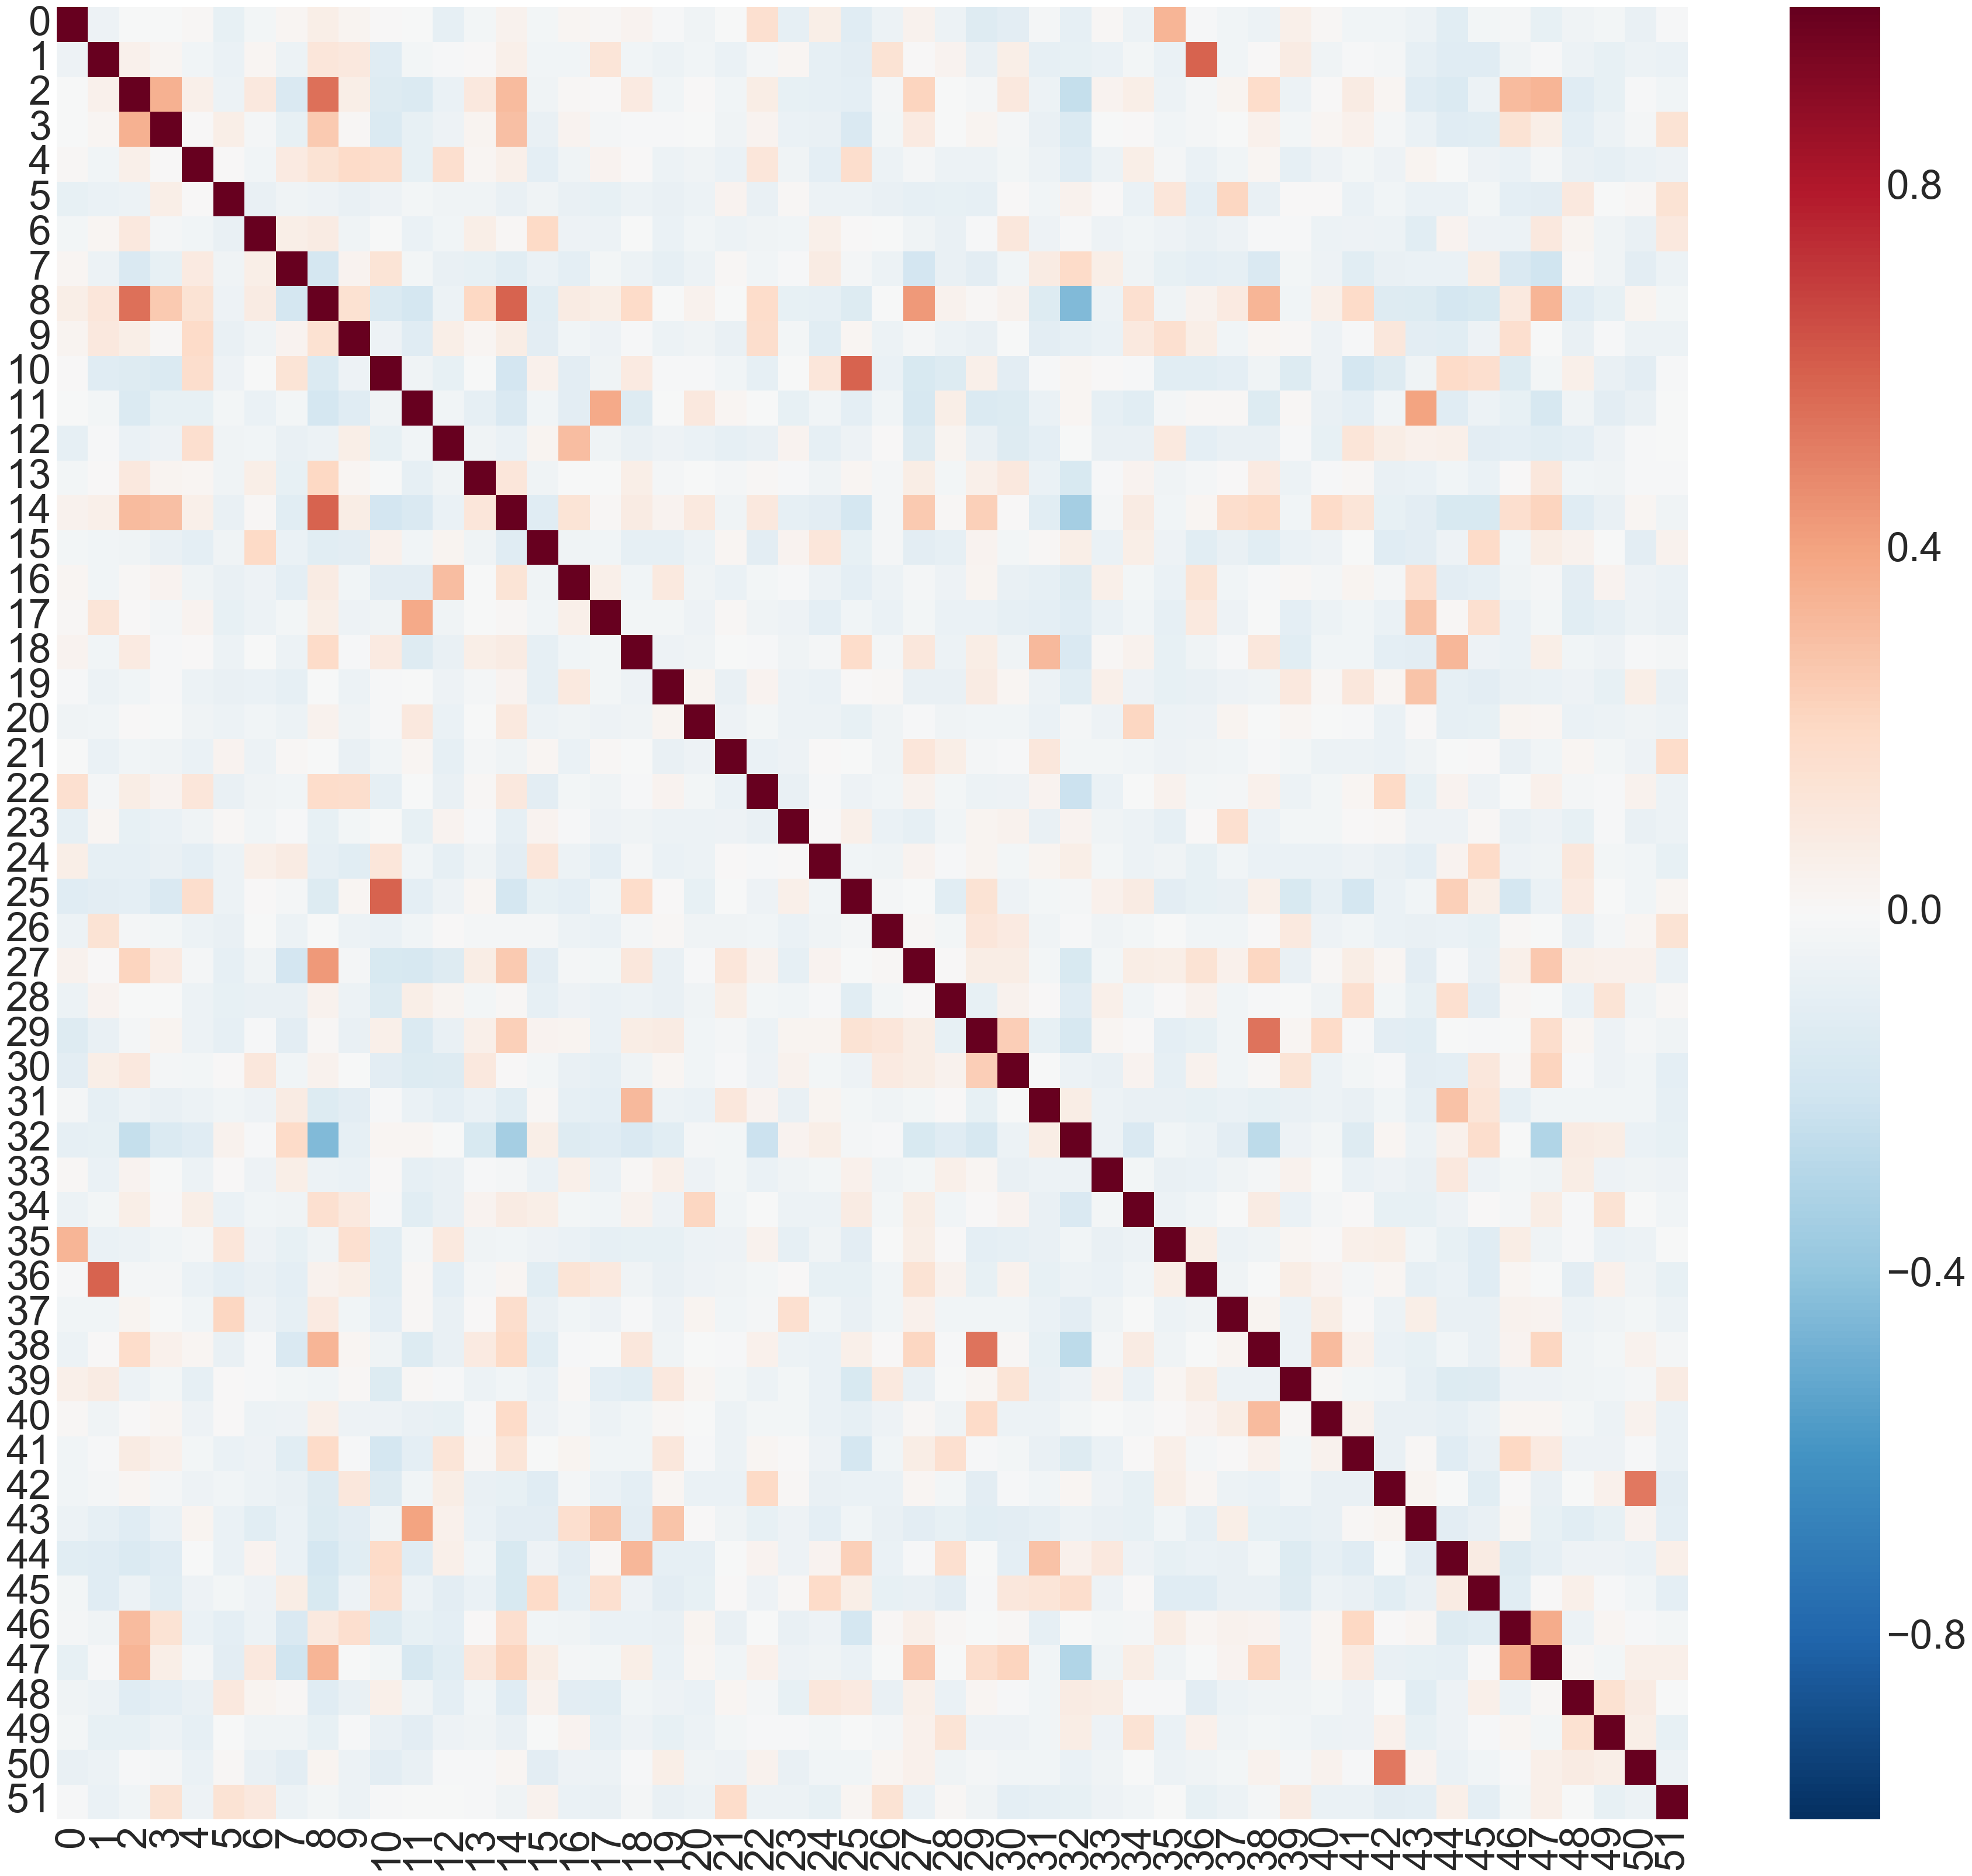

In [421]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


def X(chosen_individual):

    # select user for targeting source / target gender subsets
    user_row = data_total[data_total.Ids == chosen_individual]
    source_gender, target_gender  =  user_row[['From', 'To']].values.tolist()[0]
    
    age = user_row.categorized_age.values[0]
    city = user_row.City.values[0]
    prefrence = user_row.gay.values[0]
    
    # subset data based on source "chosen individual"
    
    if source_gender == 'm'   and user_row.gay.values[0] == 1:
        fro = 'm'
    elif source_gender == 'm' and user_row.gay.values[0] == 0:
        fro = 'w'
    elif source_gender == 'w' and user_row.gay.values[0] == 1:
        fro = 'w'
    elif source_gender == 'w' and user_row.gay.values[0] == 0:
        fro = 'm'

    
    source_target_mask =((data_total.City == city) &
                         (data_total.categorized_age == age) & 
                         (data_total.gay == prefrence) &
                         (data_total.From == fro))
    
    subset_gender_df = data_total[source_target_mask]
    
#   print subset_gender_df.shape, user_row.shape
    subset_gender_df = subset_gender_df.append(user_row)

    
    # Select only comparable features
    
    feature_columns               =  subset_gender_df.columns.values[11:]
    
    scaled = scaler.fit_transform(subset_gender_df[feature_columns])

    cosine_sim = cosine_similarity(scaled, scaled)

    
    # make cosine easier to look at
    cosine_df        =  pd.DataFrame(cosine_sim, columns=subset_gender_df['Ids'])
    cosine_df.index  =  subset_gender_df['Ids']
    cosine_df.index  =  cosine_df.index.map(lambda value: int(value))
    cosine_df.columns = [int(col) for col in cosine_df.columns]
    
    
    # Who is my chosen user and their sim users?
    mask = (cosine_df.index == chosen_individual) 

    # total hack.. removing dupes if they exists the "hacky" way
    cosine_df =  cosine_df[mask].head(1) if cosine_df[mask].shape[0] > 1 else cosine_df[mask]
    recs = pd.DataFrame(cosine_df.T)
    recs.columns = ["cosine"]
    
    plt.figure(figsize=(45,40))
    sns.set(font_scale=5)
    sns.heatmap(cosine_sim)
    
    # sorting to get the ids for the top 5 users    
    recs = (recs.sort_values('cosine', ascending = False)).head(7)
    index_list = recs.index
    
    # returning the final df with the top 5 recomendation
    f_df = data_total.loc[data_total['Ids'].isin(index_list)]

    return f_df
    
    
d = X(5975099543)

In [422]:
d

,Unnamed: 0_x,Ids,City,Who_to,Body,URL,From,To,gay,From_binary,...,locked eyes,every time,black hair,love talk,dark hair.1,every day,saturday night,stop thinking,black guy,str_id
18,18,5.967080e+09,austin,"[w, m]",Brodie - we met in your car.You posted here a ...,http://austin.craigslist.org/mis/5967080213.html,w,m,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5967080213
35,35,5.967252e+09,austin,"[w, m]",Met one of your people. Now I know for sure wh...,http://austin.craigslist.org/mis/5967251920.html,w,m,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5967251920
42,42,5.963730e+09,austin,"[w, m]",Every time I hear the sound of a police siren ...,http://austin.craigslist.org/mis/5963730257.html,w,m,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5963730257
99,99,5.975100e+09,austin,"[m, w]",Sharen we met at court today. Your beautiful b...,http://austin.craigslist.org/mis/5975099543.html,m,w,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5975099543
162,162,5.982316e+09,austin,"[w, m]",We are careening in space eyes glittering. Som...,http://austin.craigslist.org/mis/5982315656.html,w,m,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5982315656
217,217,5.985599e+09,austin,"[w, m]",Hey stud! You came to my place about a week ag...,http://austin.craigslist.org/mis/5985599428.html,w,m,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5985599428
314,314,5.972737e+09,austin,"[w, m]",One last time. I see you all the time and it's...,http://austin.craigslist.org/mis/5972737309.html,w,m,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5972737309


In [423]:
d.Body.values

array([ "Brodie - we met in your car.You posted here a few weeks ago looking for me - you were ready. Well so am I - so let's do this. Wanting you.",
       'Met one of your people. Now I know for sure what you and yours are all about.You and your friends appear to be very bad people.You set me up had me almost murdered by cops then locked up. I never recovered. You have even gone after my kid...you and your perfect friends because you all are so much better than everyone else.When I attempted to flee...you hacked so you could inflict more damage and take what little I had left.Well you are privileged and you will continue I reckon unabated.But my eyes now look beyond  the pain and sorrow you caused me and my family.All bad things end and your friends and (Hannah F)....will continue with the unwarranted cruelties till I am no more.But all bad things end.',
       'Every time I hear the sound of a police siren my heart sinks deep into the pit of my stomach.  Is today the day that the wo

In [223]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


def X(chosen_individual):

    # select user for targeting source / target gender subsets
    user_row = data_total[data_total.Ids == chosen_individual]

    # subset data based on source "chosen individual"
    source_gender, target_gender  =  user_row[['From', 'To']].values.tolist()[0]
    source_target_mask            =  (data_total.From == source_gender) & (data_total.To == target_gender)
    subset_gender_df              =  data_total[source_target_mask]
    
    # Select only comparable features
    feature_columns               =  subset_gender_df.columns.values[11:]

    scaled = scaler.fit_transform(subset_gender_df[feature_columns])

    cosine_sim = cosine_similarity(scaled, scaled)

    # make cosine easier to look at
    cosine_df        =  pd.DataFrame(cosine_sim, columns=data_total[source_target_mask]['Ids'])
    cosine_df.index  =  data_total[source_target_mask]['Ids']
    cosine_df.index  =  cosine_df.index.map(lambda value: int(value))
    cosine_df.columns = [int(col) for col in cosine_df.columns]

    # Who is my chosen user and their sim users?
    recs = pd.DataFrame(cosine_df[cosine_df.index == chosen_individual].T)
    print recs
#     recs.columns = ['cosine']
    
#     # sorting to get the ids for the top 5 users    
#     recs = (recs.sort_values('cosine', ascending = False)).head(5)
    
#     return recs
    
    
d = X(5964900703)

            5964900703
5962895842    0.010419
5967210778    0.118099
5964900703    1.000000
5968179475    0.051649
5965756167   -0.007313
5964948350   -0.026350
5963768516   -0.004258
5963930864   -0.023142
5972692308   -0.033681
5974488684   -0.027841
5964143316    0.135469
5964211702   -0.022972
5974360256    0.022929
5972817435    0.229095
5970874319    0.012840
5974832587   -0.040213
5974771295    0.013812
5974340520    0.138484
5974664707    0.025375
5968222855    0.166650
5969910630   -0.049638
5964163797    0.016912
5965702493    0.078289
5961140651   -0.035382
5967622965   -0.032122
5965881780    0.081712
5966283283   -0.002898
5965279392   -0.012617
5968318573   -0.019261
5965720428   -0.032997
...                ...
5977368493    0.000966
5977330827   -0.082717
5974414079   -0.069907
5977358765   -0.102943
5974161197    0.198111
5977288694    0.012797
5980217377   -0.089896
5980570736   -0.072438
5974404979   -0.088376
5980592510    0.151245
5980243849    0.043278
5980218494 